# Laptop Price Classification

<div style="text-align:center">
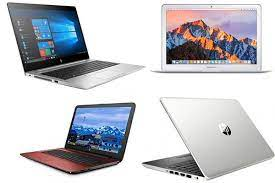
</div>

## Import libraries

In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

from termcolor import colored

import warnings 
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",None)
pd.set_option("display.width",600)
pd.set_option('display.float_format', lambda x: '%.5f' % x) 

from sklearn.impute import KNNImputer
import miceforest as mf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

from pycaret.classification import*

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import joblib

## EDA

In [380]:
df = pd.read_excel("data.xlsx")
df.head()

,Bellek Hızı,Cihaz Ağırlığı,Ekran Boyutu,Ekran Kartı Bellek Tipi,Ekran Kartı Hafızası,Ekran Kartı Tipi,Ekran Panel Tipi,İşlemci Nesli,İşlemci,İşletim Sistemi,Kart Okuyucu,Aydınlatma,Maksimum İşlemci Hızı,Max Ekran Çözünürlüğü,Parmak İzi Okuyucu,Ram (Sistem Belleği),SSD Kapasitesi,Ürün Modeli,Fiyat
0,1066 MHz,NaN,10 inç,NaN,1 GB,NaN,IPS,1.Nesil,1000M,Android,NaN,0,"1,05 GHz",NaN,NaN,NaN,1 TB,Notebook,Çok Yüksek
1,1066 MHz,NaN,10 inç,NaN,1 GB,NaN,IPS,1.Nesil,1000M,Android,NaN,0,"1,05 GHz",NaN,NaN,NaN,1 TB,Notebook,Çok Yüksek
2,1066 MHz,NaN,10 inç,NaN,1 GB,NaN,IPS,1.Nesil,1000M,Android,NaN,0,"1,05 GHz",NaN,NaN,NaN,1 TB,Notebook,Orta
3,3200 MHz,1 - 2 kg,"15,6 inç",GDDR4,2 GB,Harici Ekran Kartı,LED,10. Nesil,1035G1,Windows 10 Home,Var,0,"3,6 GHz",1920 x 1080,Yok,8 GB,512 GB,Notebook,Düşük
4,3200 MHz,1 - 2 kg,"15,6 inç",GDDR5,2 GB,Harici Ekran Kartı,LED,10. Nesil,1035G1,Windows 10 Home,Yok,0,"3,6 GHz",1920 x 1080,Yok,12 GB,1 TB,Notebook,Düşük


In [381]:
def check_df(df, head=5, tail=5):
    print(" SHAPE ".center(70, '*'))
    print('Observations -------> {}'.format(df.shape[0]))
    print('Features     -------> {}'.format(df.shape[1]))
    print(f"Shape of dataset: {colored(df.shape, 'red')}")
    print(" TYPES OF FEATURES ".center(70, '*'))
    print(df.dtypes,"\n")
    print(" INFO ".center(70, "*"))
    print("\n",df.info(),"\n")
    print(' DUPLICATE VALUE ANALYSIS '.center(70, '*'))
    print("\n",df.duplicated().sum(),"\n")
    print(" QUANTILES ".center(70, '*'))
    numerical_df = df.select_dtypes(include=["number"])
    print(numerical_df.quantile([0, 0.05, 0.50, 0.95, 0.90, 1]).T, "\n")
    print(" MISSING VALUES ".center(70, "*"))
    print(df.isnull().sum())

check_df(df)

******************************* SHAPE ********************************
Observations -------> 994
Features     -------> 19
Shape of dataset: (994, 19)
************************* TYPES OF FEATURES **************************
Bellek Hızı                object
Cihaz Ağırlığı             object
Ekran Boyutu               object
Ekran Kartı Bellek Tipi    object
Ekran Kartı Hafızası       object
Ekran Kartı Tipi           object
Ekran Panel Tipi           object
İşlemci Nesli              object
İşlemci                    object
İşletim Sistemi            object
Kart Okuyucu               object
Aydınlatma                  int64
Maksimum İşlemci Hızı      object
Max Ekran Çözünürlüğü      object
Parmak İzi Okuyucu         object
Ram (Sistem Belleği)       object
SSD Kapasitesi             object
Ürün Modeli                object
Fiyat                      object
dtype: object 

******************************** INFO ********************************
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [382]:
df = df.drop_duplicates()
df.shape

(742, 19)

In [383]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Aydınlatma,742.00000,0.25067,0.43369,0.00000,0.00000,0.00000,0.75000,1.00000


In [384]:
df.describe(include="object").T

,count,unique,top,freq
Bellek Hızı,663,16,3200 MHz,480
Cihaz Ağırlığı,735,4,1 - 2 kg,434
Ekran Boyutu,742,17,"15,6 inç",514
Ekran Kartı Bellek Tipi,664,7,Onboard,378
Ekran Kartı Hafızası,714,8,Paylaşımlı,434
Ekran Kartı Tipi,720,3,Dahili Ekran Kartı,434
Ekran Panel Tipi,742,10,IPS,464
İşlemci Nesli,716,22,11.Nesil,257
İşlemci,730,87,1135G7,105
İşletim Sistemi,742,9,Yok (Free Dos),359


## Handling missing values and Feature Engineering

In [385]:
df.isnull().sum()

Bellek Hızı                79
Cihaz Ağırlığı              7
Ekran Boyutu                0
Ekran Kartı Bellek Tipi    78
Ekran Kartı Hafızası       28
Ekran Kartı Tipi           22
Ekran Panel Tipi            0
İşlemci Nesli              26
İşlemci                    12
İşletim Sistemi             0
Kart Okuyucu               96
Aydınlatma                  0
Maksimum İşlemci Hızı      25
Max Ekran Çözünürlüğü       4
Parmak İzi Okuyucu         80
Ram (Sistem Belleği)        6
SSD Kapasitesi              3
Ürün Modeli                 0
Fiyat                       0
dtype: int64

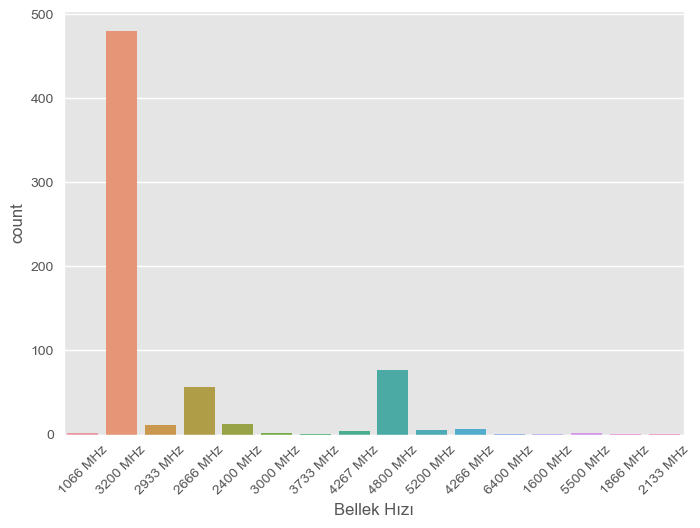

In [386]:
plt.figure()
plt.xticks(rotation=45)
sns.countplot(x = df["Bellek Hızı"]);

In [387]:
df["Bellek Hızı"].fillna(df["Bellek Hızı"].mode()[0], inplace=True)


In [388]:
df["Bellek Hızı"] = df["Bellek Hızı"].str.replace("MHz","").astype(int)

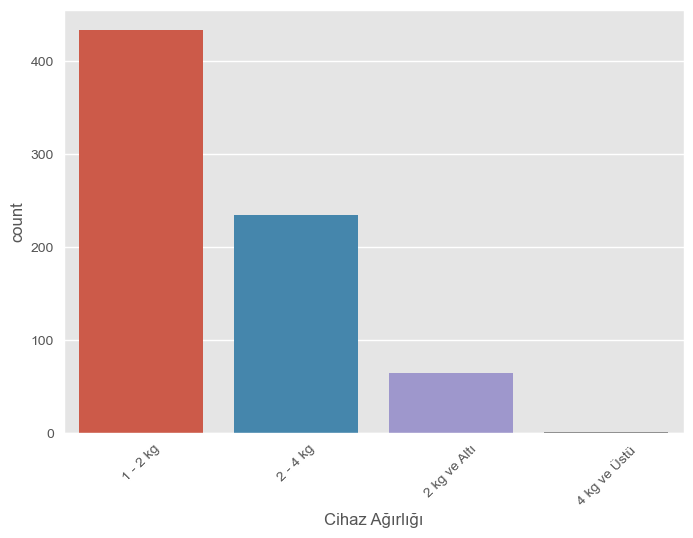

In [389]:
plt.figure()
plt.xticks(rotation=45)
sns.countplot(x = df["Cihaz Ağırlığı"]);

In [390]:
df["Cihaz Ağırlığı"].fillna(df["Cihaz Ağırlığı"].mode()[0], inplace=True)

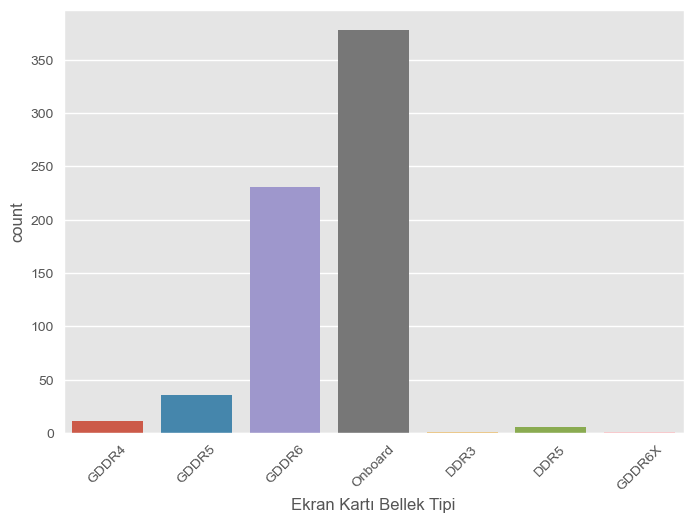

In [391]:
plt.figure()
plt.xticks(rotation=45)
sns.countplot(x = df["Ekran Kartı Bellek Tipi"]);

In [392]:
df["Ekran Kartı Bellek Tipi"] = np.where(df["Ekran Kartı Hafızası"] == "Paylaşımlı", 
                                         "Onboard", 
                                         df["Ekran Kartı Bellek Tipi"])


In [393]:
df["Ekran Kartı Bellek Tipi"].fillna("GDDR6", inplace=True)

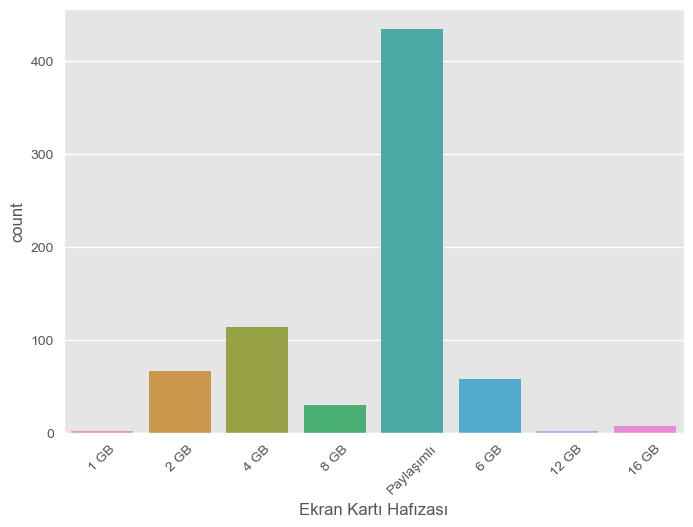

In [394]:
plt.figure()
plt.xticks(rotation=45)
sns.countplot(x = df["Ekran Kartı Hafızası"]);

In [395]:
df.groupby("Ekran Kartı Bellek Tipi")["Ekran Kartı Hafızası"].apply(lambda x: x.mode()[0])

Ekran Kartı Bellek Tipi
DDR5             2 GB
GDDR4            2 GB
GDDR5            2 GB
GDDR6            4 GB
GDDR6X           8 GB
Onboard    Paylaşımlı
Name: Ekran Kartı Hafızası, dtype: object

In [396]:
df["Ekran Kartı Hafızası"] = np.where(df["Ekran Kartı Bellek Tipi"]=="Onboard", "Paylaşımlı", df["Ekran Kartı Hafızası"])
df["Ekran Kartı Hafızası"].fillna("4 GB", inplace=True)

In [397]:
df["Ekran Kartı Hafızası"] = df["Ekran Kartı Hafızası"].str.replace("GB","").str.replace("Paylaşımlı","5").astype(int)


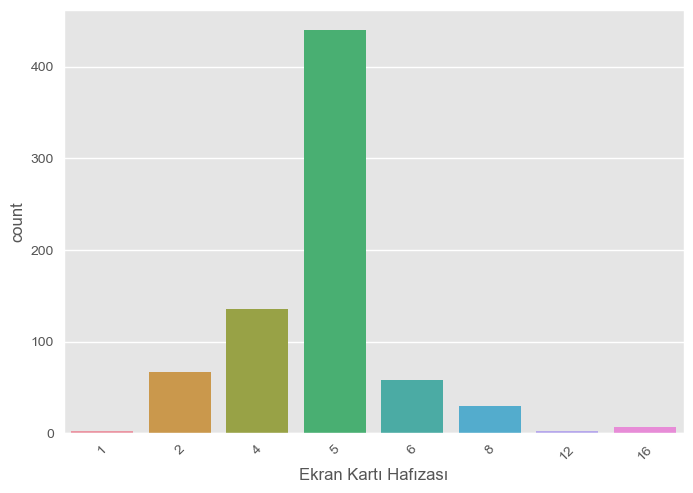

In [398]:
plt.figure()
plt.xticks(rotation=45)
sns.countplot(x = df["Ekran Kartı Hafızası"]);

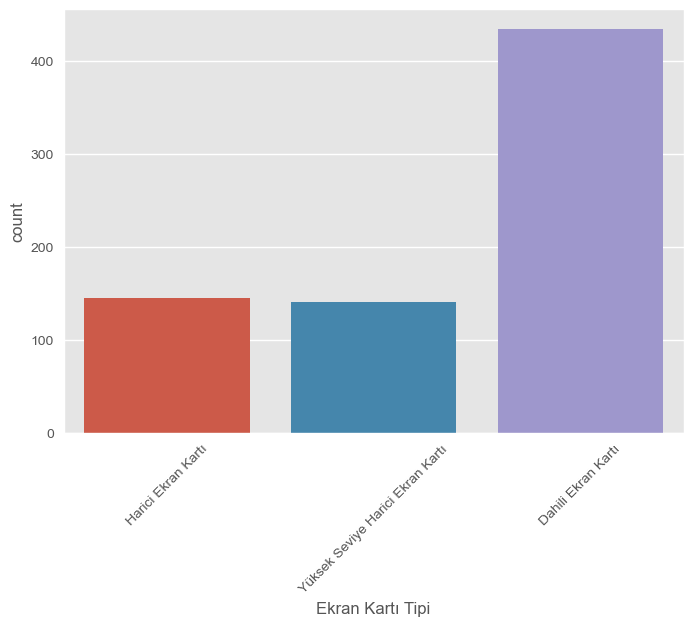

In [399]:
plt.figure()
plt.xticks(rotation=45)
sns.countplot(x = df["Ekran Kartı Tipi"]);

In [400]:
df.groupby("Ekran Kartı Bellek Tipi")["Ekran Kartı Tipi"].apply(lambda x: x.mode()[0])

Ekran Kartı Bellek Tipi
DDR5                     Harici Ekran Kartı
GDDR4                    Dahili Ekran Kartı
GDDR5                    Harici Ekran Kartı
GDDR6      Yüksek Seviye Harici Ekran Kartı
GDDR6X     Yüksek Seviye Harici Ekran Kartı
Onboard                  Dahili Ekran Kartı
Name: Ekran Kartı Tipi, dtype: object

In [401]:
df["Ekran Kartı Tipi"] = np.where(df["Ekran Kartı Bellek Tipi"]=="Onboard", "Dahili Ekran Kartı", df["Ekran Kartı Tipi"])
df["Ekran Kartı Tipi"].fillna("Yüksek Seviye Harici Ekran Kartı", inplace=True)

In [402]:
d = {"Dahili Ekran Kartı":1, "Harici Ekran Kartı":2, "Yüksek Seviye Harici Ekran Kartı":3}
df["Ekran Kartı Tipi"] = df["Ekran Kartı Tipi"].map(d)

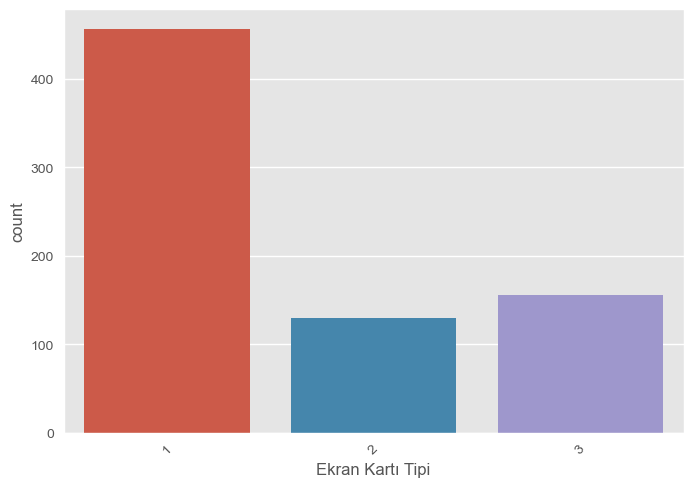

In [403]:
plt.figure()
plt.xticks(rotation=45)
sns.countplot(x = df["Ekran Kartı Tipi"]);

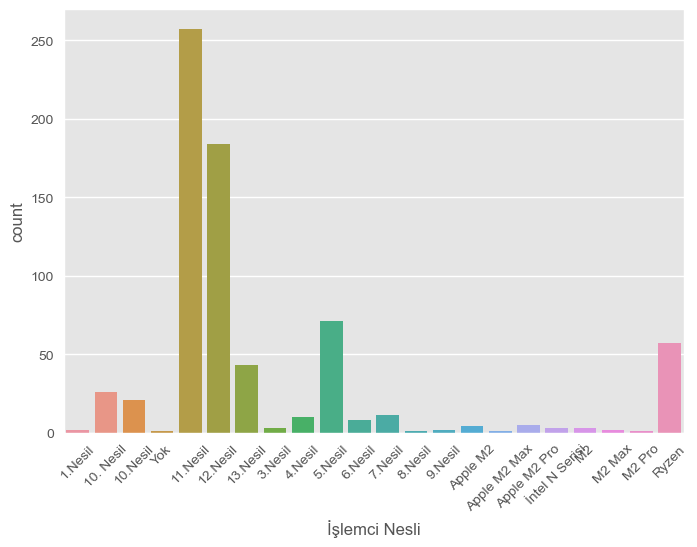

In [404]:
plt.figure()
plt.xticks(rotation=45)
sns.countplot(x = df["İşlemci Nesli"]);


In [405]:
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="1255U") & (df["İşlemci Nesli"].isna()), "12. Nesil", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="12700H") & (df["İşlemci Nesli"].isna()), "12. Nesil", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="12500H") & (df["İşlemci Nesli"].isna()), "12. Nesil", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="Apple M1") & (df["İşlemci Nesli"].isna()), "Apple M1", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="Apple M2") & (df["İşlemci Nesli"].isna()), "Apple M2", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="N4020") & (df["İşlemci Nesli"].isna()), "Ryzen", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="1155G7") & (df["İşlemci Nesli"].isna()), "11. Nesil", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="N4150") & (df["İşlemci Nesli"].isna()), "Ryzen", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="N4000") & (df["İşlemci Nesli"].isna()), "Ryzen", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="N4500") & (df["İşlemci Nesli"].isna()), "Ryzen", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="N5030") & (df["İşlemci Nesli"].isna()), "Yok", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="1260P") & (df["İşlemci Nesli"].isna()), "12", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="1240P") & (df["İşlemci Nesli"].isna()), "12", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="1235U") & (df["İşlemci Nesli"].isna()), "12", df["İşlemci Nesli"])
df["İşlemci Nesli"] = np.where((df["İşlemci"]=="Celeron N4020") & (df["İşlemci Nesli"].isna()), "4.Nesil", df["İşlemci Nesli"])
df["İşlemci Nesli"].fillna("Yok", inplace=True)

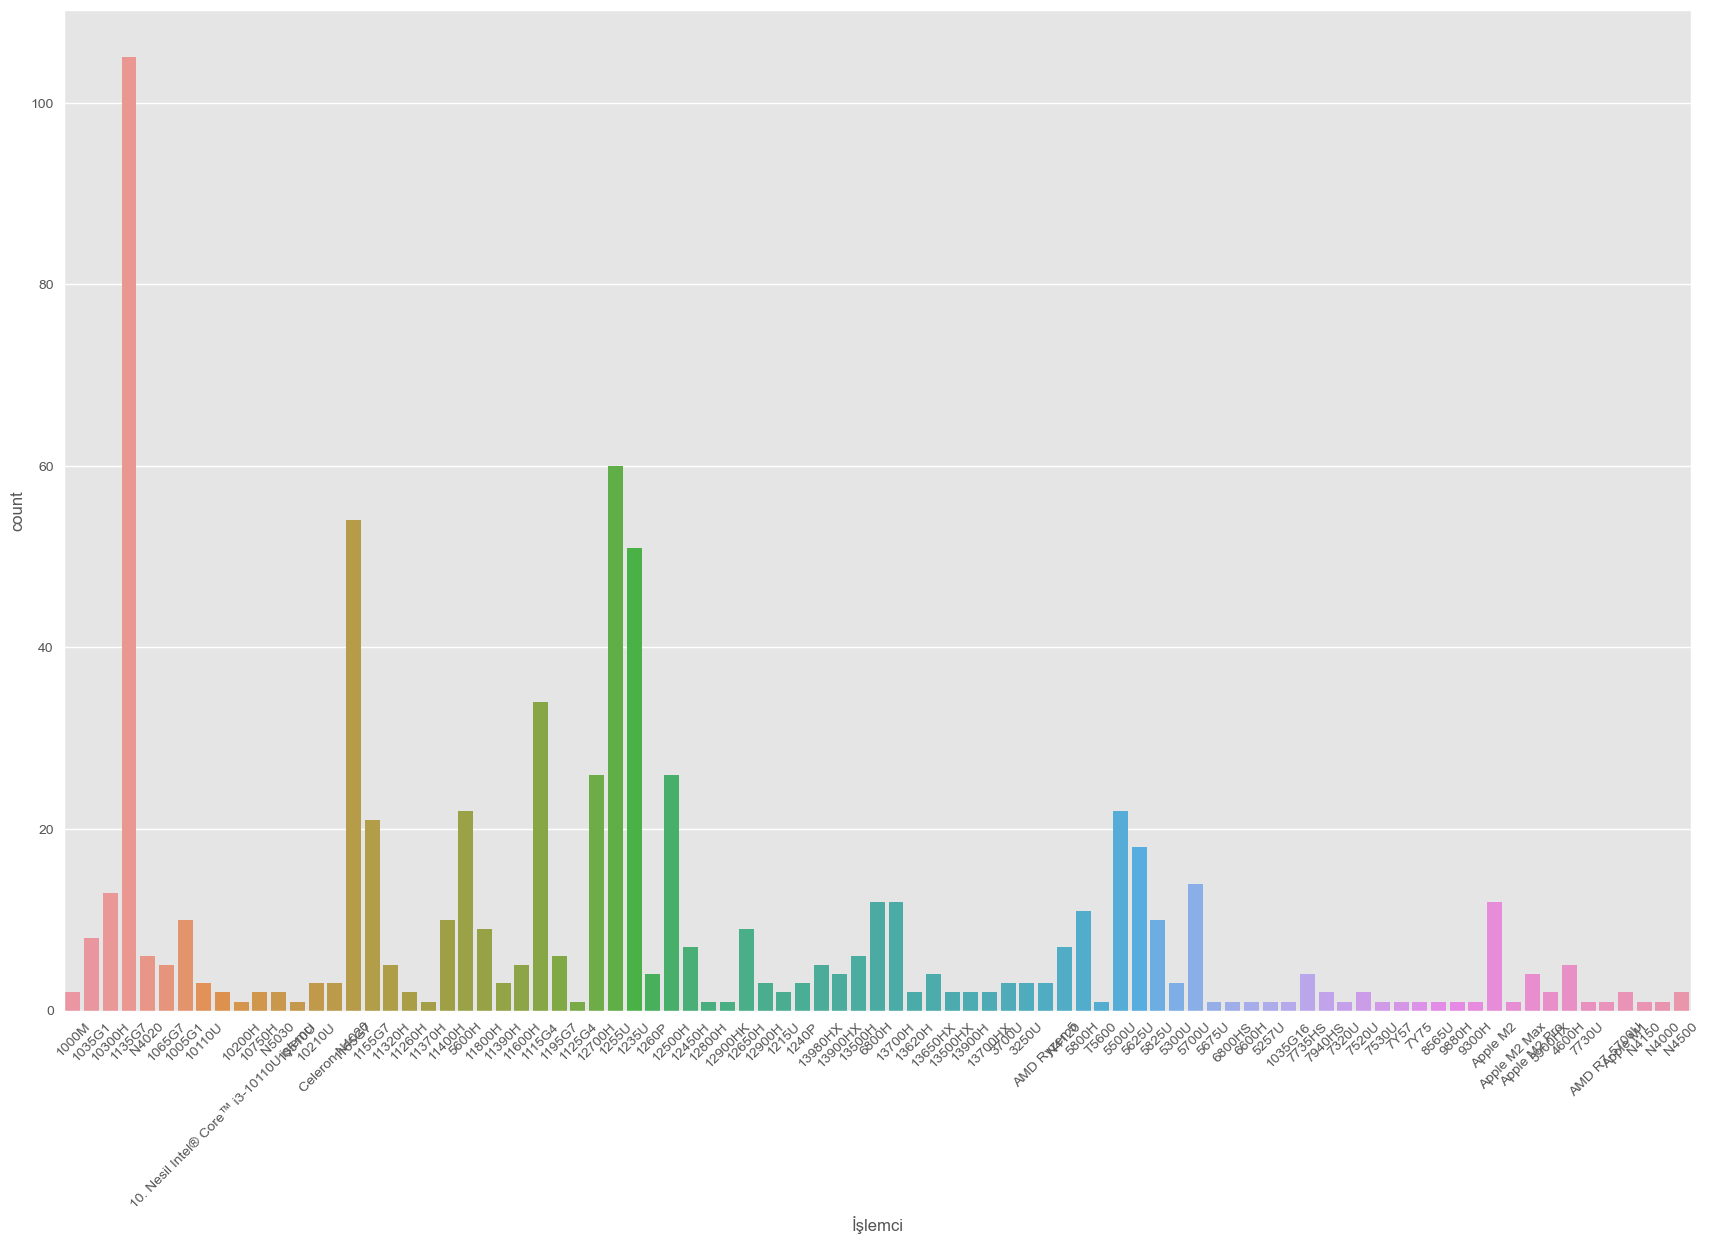

In [406]:
plt.figure(figsize=(21,13))
plt.xticks(rotation=45)
sns.countplot(x = df["İşlemci"]);


In [407]:
df["İşlemci"] = np.where((df["İşlemci Nesli"]=="11.Nesil") & (df["İşlemci"].isna()), "1165G7", df["İşlemci"])
df["İşlemci"] = np.where((df["İşlemci Nesli"]=="12.Nesil") & (df["İşlemci"].isna()), "1255U", df["İşlemci"])
df["İşlemci"] = np.where((df["İşlemci Nesli"]=="13.Nesil") & (df["İşlemci"].isna()), "13980HX", df["İşlemci"])
df["İşlemci"] = np.where((df["İşlemci Nesli"]=="4.Nesil") & (df["İşlemci"].isna()), "N4120", df["İşlemci"])
df["İşlemci"] = np.where((df["İşlemci Nesli"]=="Apple M2") & (df["İşlemci"].isna()), "Apple M2", df["İşlemci"])
df["İşlemci"] = np.where((df["İşlemci Nesli"]=="İntel N Serisi") & (df["İşlemci"].isna()), "10110U", df["İşlemci"])
df["İşlemci"] = np.where((df["İşlemci Nesli"]=="Ryzen") & (df["İşlemci"].isna()), "N4500", df["İşlemci"])
df["İşlemci"] = np.where((df["İşlemci Nesli"]=="Yok") & (df["İşlemci"].isna()), "10300H", df["İşlemci"])


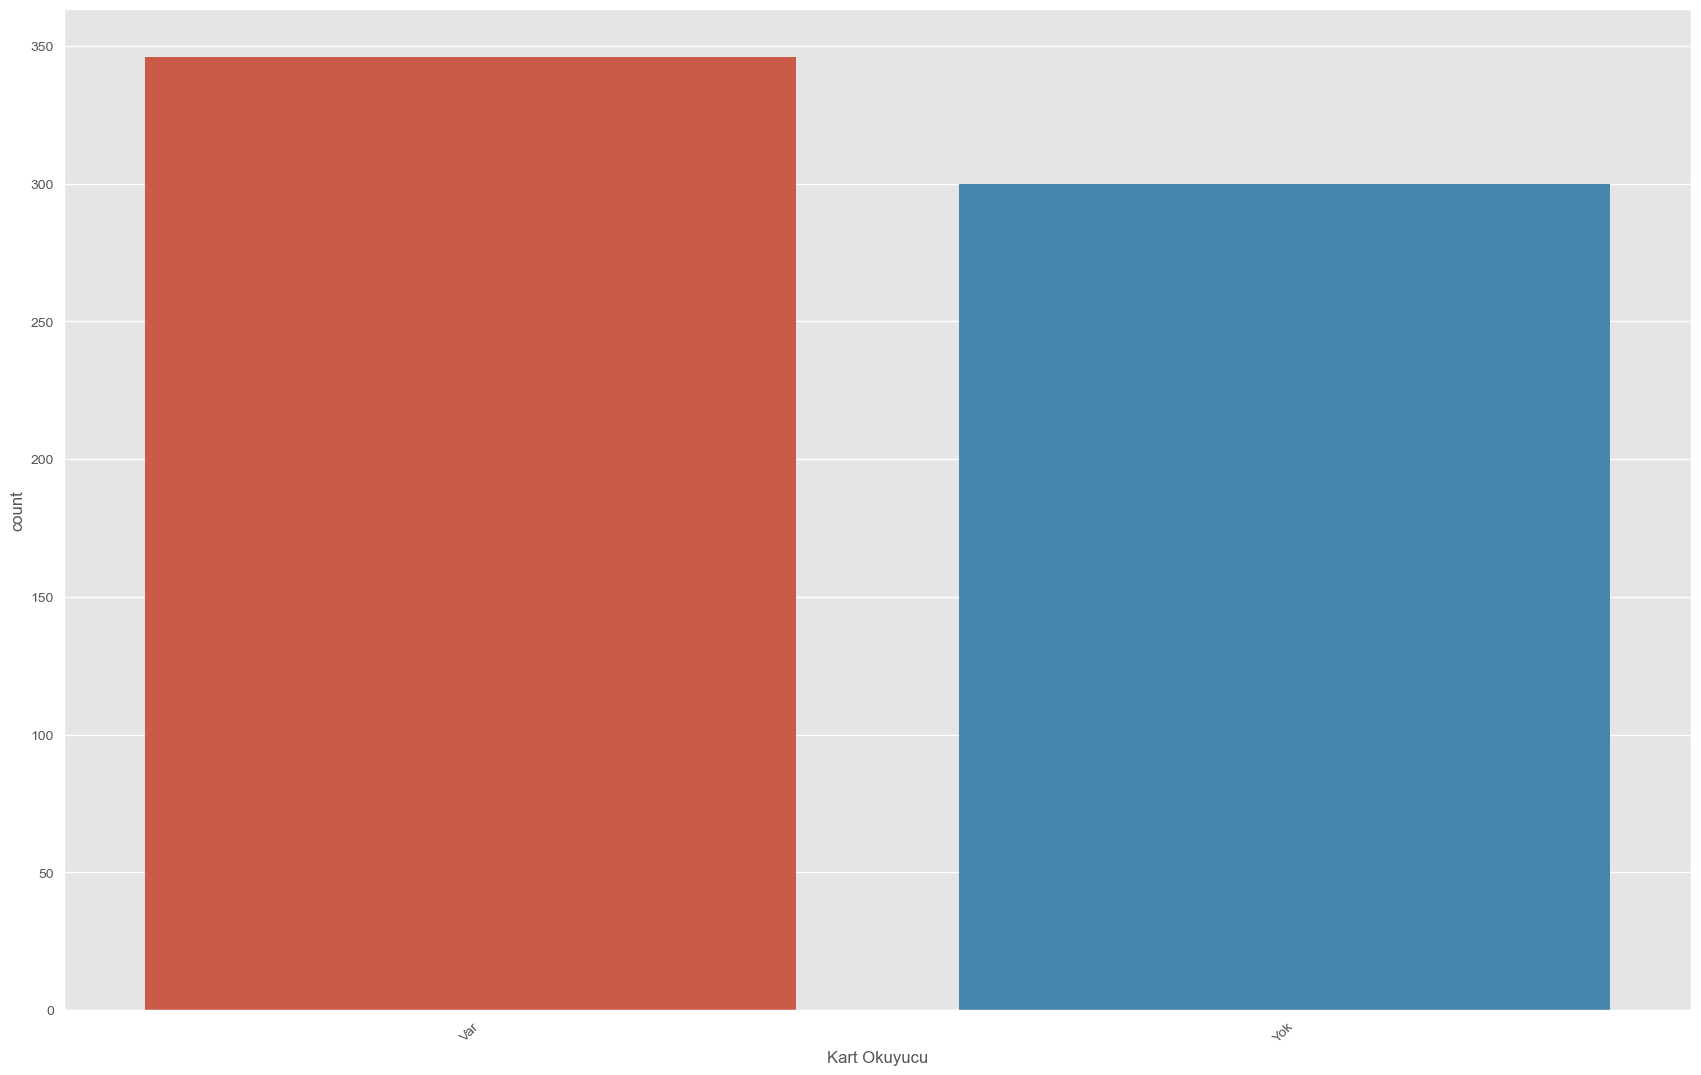

In [408]:
plt.figure(figsize=(21,13))
plt.xticks(rotation=45)
sns.countplot(x = df["Kart Okuyucu"]);

In [409]:
df["Kart Okuyucu"].fillna("Yok", inplace=True)

In [410]:
df["Kart Okuyucu"] = df["Kart Okuyucu"].replace({"Yok":0, "Var":1}).astype(int)

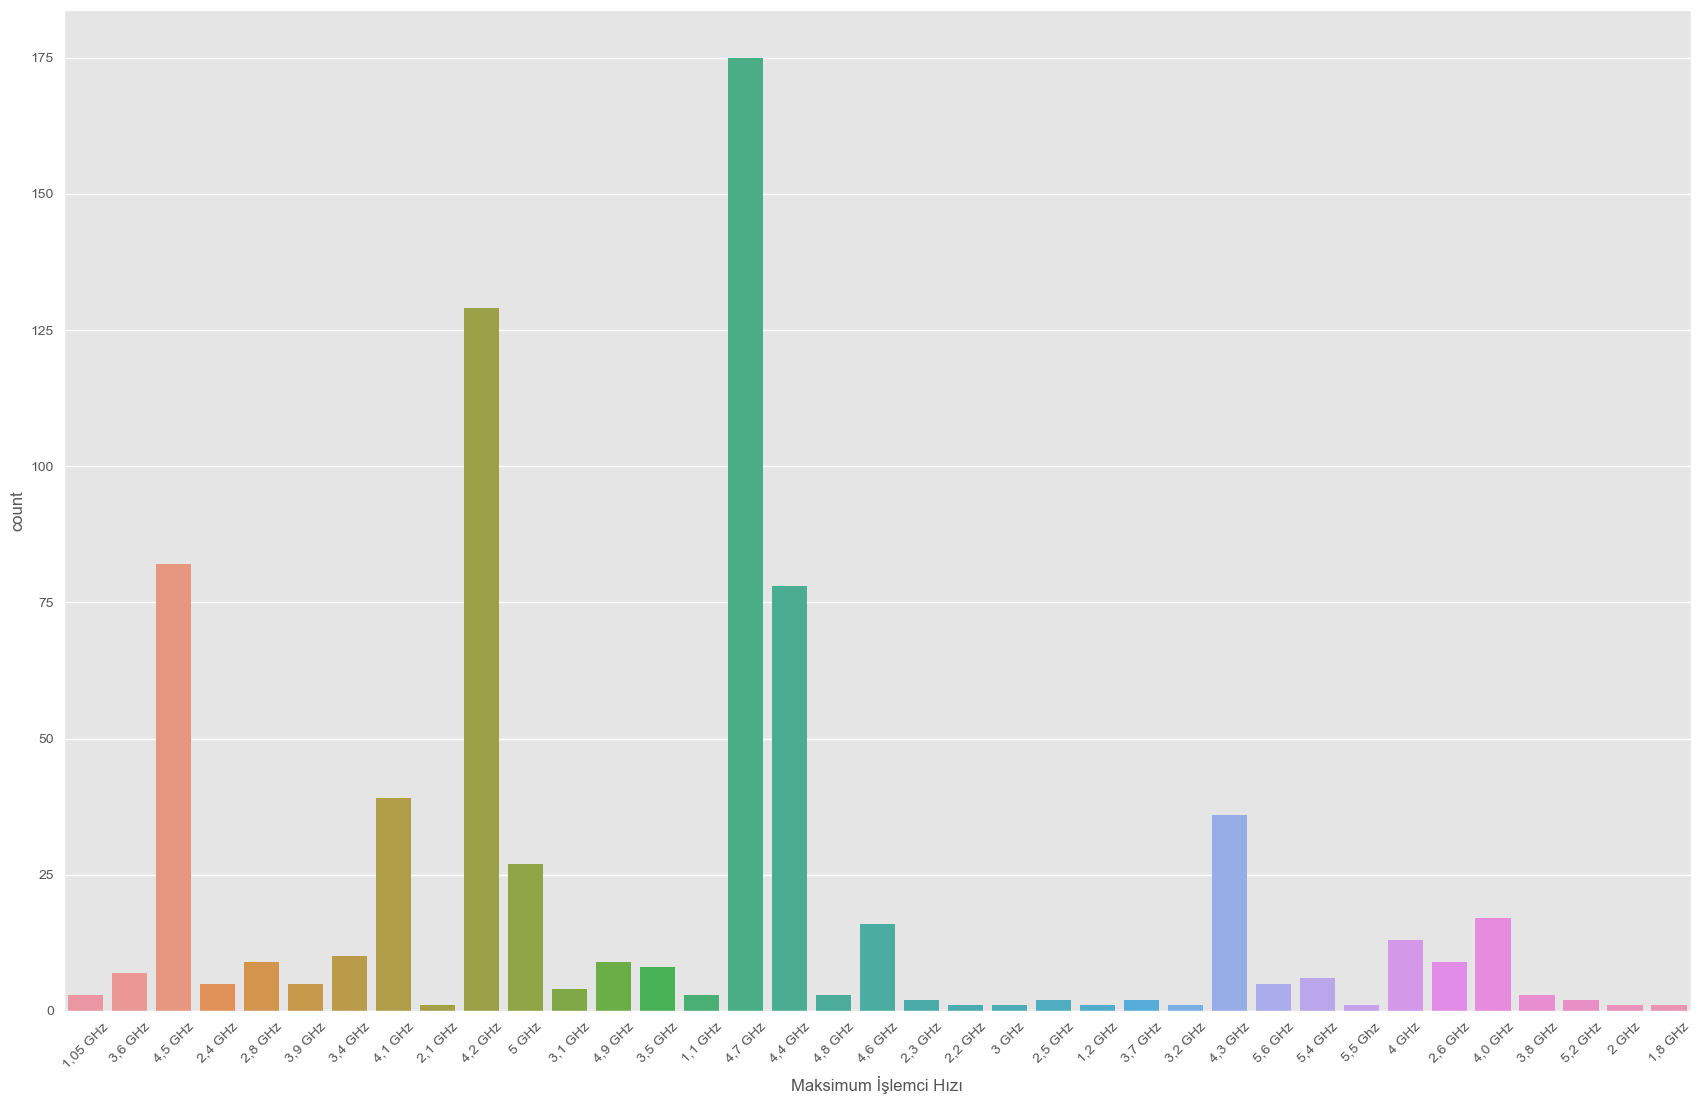

In [411]:
plt.figure(figsize=(21,13))
plt.xticks(rotation=45)
sns.countplot(x = df["Maksimum İşlemci Hızı"]);

In [412]:
mode_result = df.groupby("İşlemci")["Maksimum İşlemci Hızı"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
mode_result

İşlemci
10. Nesil Intel® Core™ i3-10110U işlemci     2,1 GHz
1000M                                       1,05 GHz
1005G1                                       3,4 GHz
10110U                                       4,1 GHz
10200H                                       4,2 GHz
                                              ...   
N4120                                        2,6 GHz
N4150                                           None
N4500                                        2,8 GHz
N5030                                        3,1 GHz
T5600                                        4,2 GHz
Name: Maksimum İşlemci Hızı, Length: 87, dtype: object

In [413]:
# Calculate the mode for each group
mode_mapping = df.groupby("İşlemci")["Maksimum İşlemci Hızı"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Map the mode values back to the original dataframe
df["Maksimum İşlemci Hızı"] = df["Maksimum İşlemci Hızı"].fillna(df["İşlemci"].map(mode_mapping))


In [414]:
df["Maksimum İşlemci Hızı"].fillna(df["Maksimum İşlemci Hızı"].mode()[0], inplace=True)

In [415]:
df["Max Ekran Çözünürlüğü"].fillna(df["Max Ekran Çözünürlüğü"].mode()[0], inplace=True)

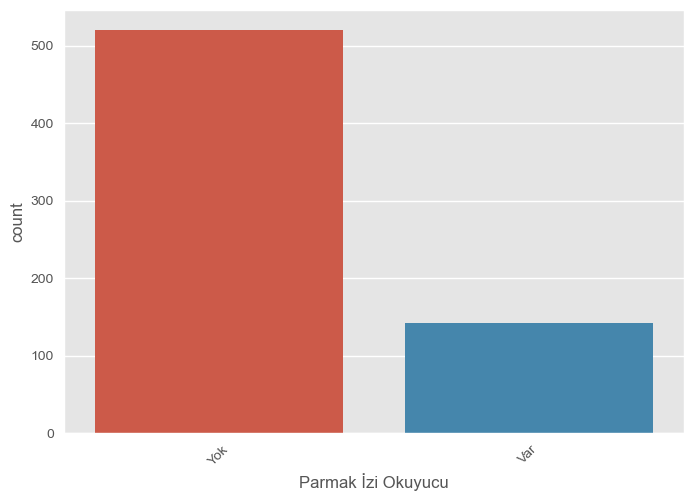

In [416]:

plt.xticks(rotation=45)
sns.countplot(x = df["Parmak İzi Okuyucu"]);


In [417]:
df["Parmak İzi Okuyucu"].fillna("Yok", inplace=True)
df["Parmak İzi Okuyucu"] = df["Parmak İzi Okuyucu"].replace({"Var":1, "Yok":0}).astype(int)

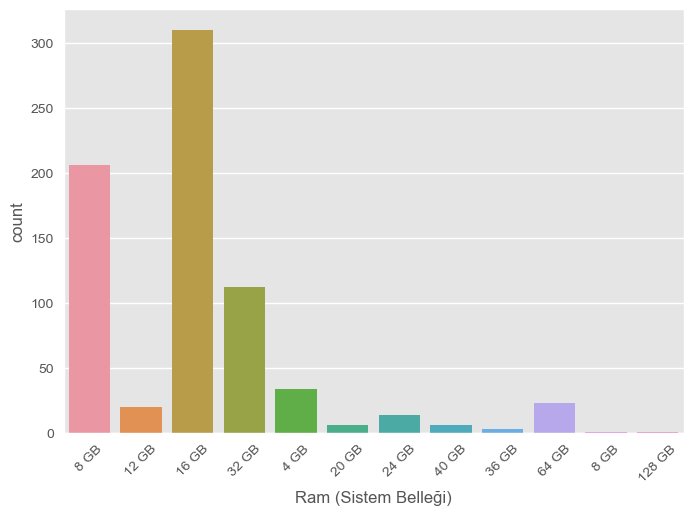

In [418]:
plt.xticks(rotation=45)
sns.countplot(x = df["Ram (Sistem Belleği)"]);


In [419]:
df["Ram (Sistem Belleği)"].fillna("16 GB", inplace=True)

In [420]:
df["Ram (Sistem Belleği)"] = df["Ram (Sistem Belleği)"].str.replace("GB","").astype(int)

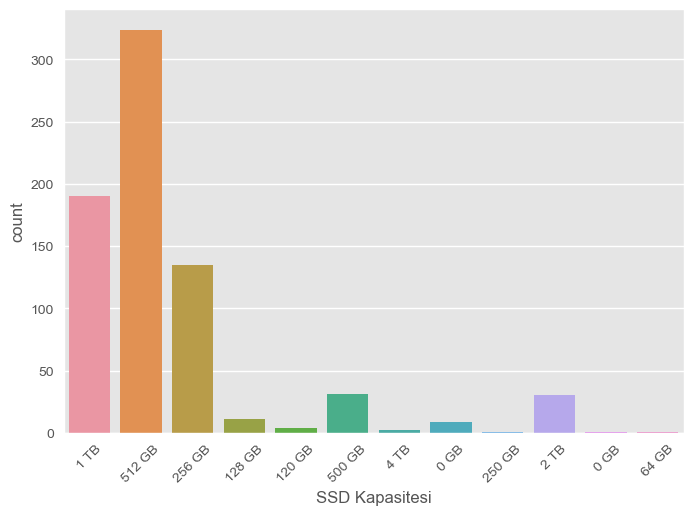

In [421]:
plt.xticks(rotation=45)
sns.countplot(x = df["SSD Kapasitesi"]);


In [422]:
 df["SSD Kapasitesi"].fillna("512 GB", inplace=True)

In [423]:
df["SSD Kapasitesi"] = df["SSD Kapasitesi"].str.replace("GB", "").str.replace("1 TB", "1024").str.replace("2 TB", "2048").str.replace("4 TB", "4096").astype(int)


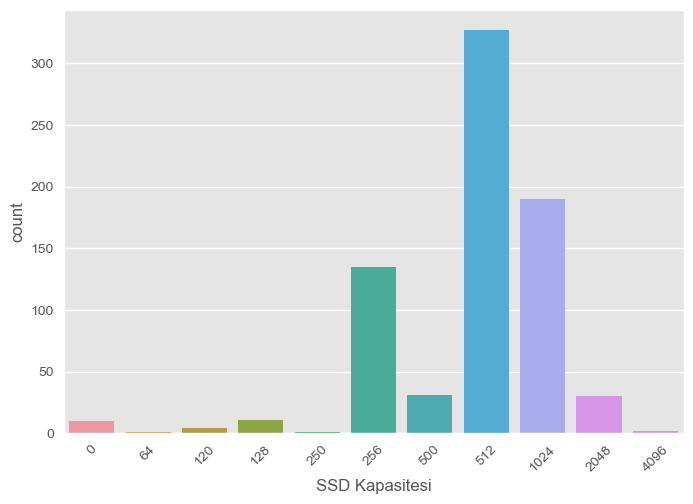

In [424]:
plt.xticks(rotation=45)
sns.countplot(x = df["SSD Kapasitesi"]);


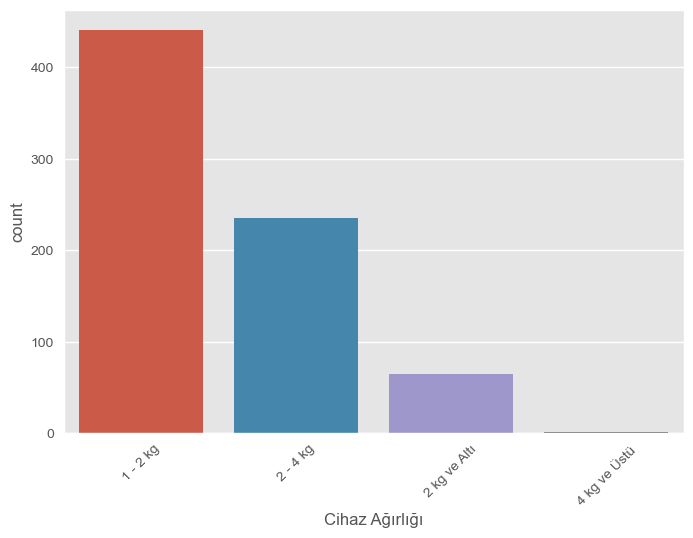

In [425]:
plt.xticks(rotation=45)
sns.countplot(x = df["Cihaz Ağırlığı"]);

In [426]:
df["Cihaz Ağırlığı"] = df["Cihaz Ağırlığı"].replace({"1 - 2 kg":"2 kg ve Altı"})

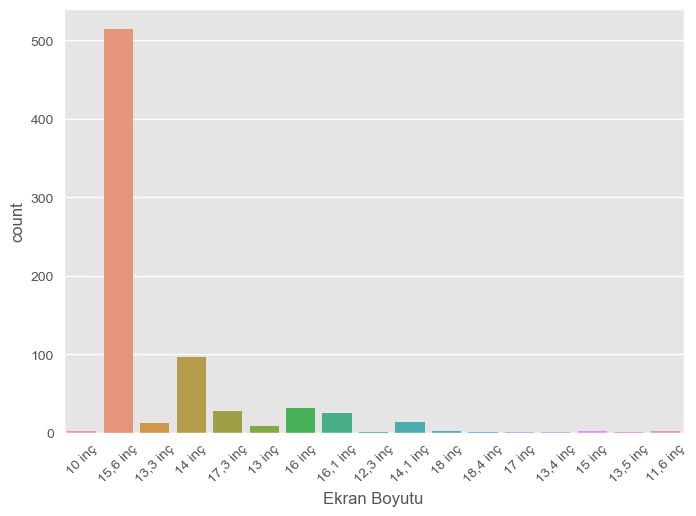

In [427]:
plt.xticks(rotation=45)
sns.countplot(x = df["Ekran Boyutu"]);


In [428]:
df["Ekran Boyutu"] = df["Ekran Boyutu"].str.replace("inç","").str.replace(",",".").astype(float)

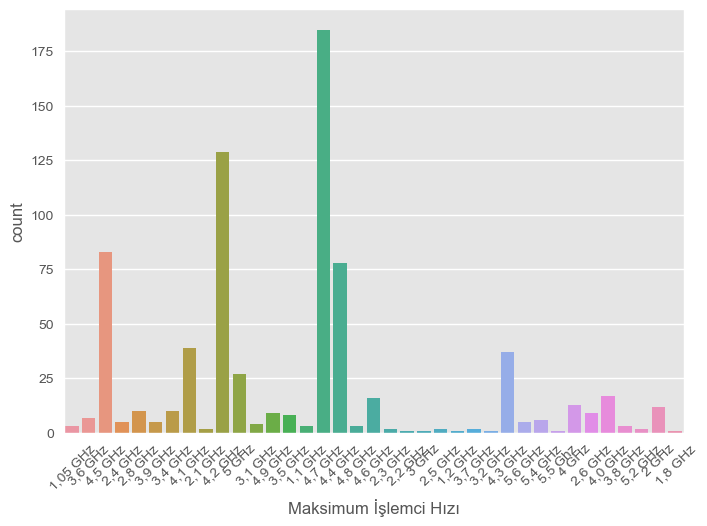

In [429]:
plt.xticks(rotation=45)
sns.countplot(x = df["Maksimum İşlemci Hızı"]);


In [430]:
df["Maksimum İşlemci Hızı"] = df["Maksimum İşlemci Hızı"].str.replace("GHz", "").str.replace("Ghz","").str.replace(",", ".").astype("float")


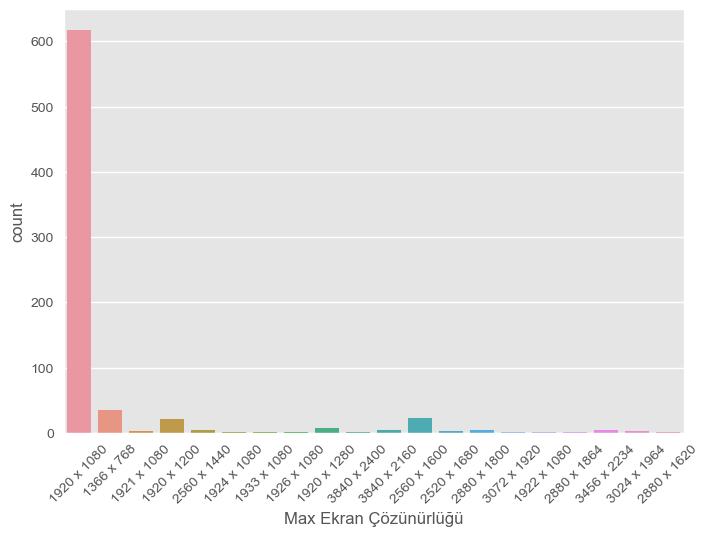

In [431]:
plt.xticks(rotation=45)
sns.countplot(x = df["Max Ekran Çözünürlüğü"]);


In [432]:
pixel = df["Max Ekran Çözünürlüğü"].str.split("x").to_list()


In [433]:
df["Max Ekran Çözünürlüğü"] = list(map(lambda x: int(x[0]) * int(x[1]), pixel))

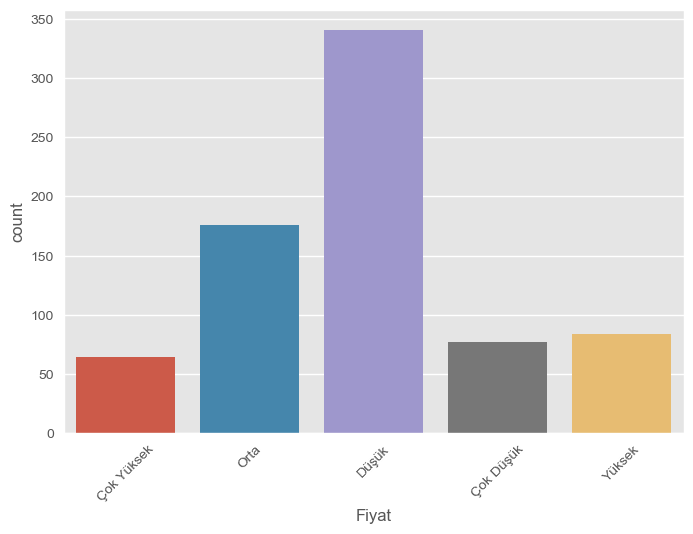

In [434]:
plt.xticks(rotation=45)
sns.countplot(x = df["Fiyat"]);

In [435]:
df["Fiyat"] = df["Fiyat"].replace({"Çok Düşük":1,
                                   "Düşük": 2,
                                   "Orta": 3,
                                   "Yüksek": 4,
                                   "Çok Yüksek": 5,
                                  }).astype(int)

In [436]:
df.to_pickle("df.pkl")

In [437]:
df = pd.read_pickle("df.pkl")


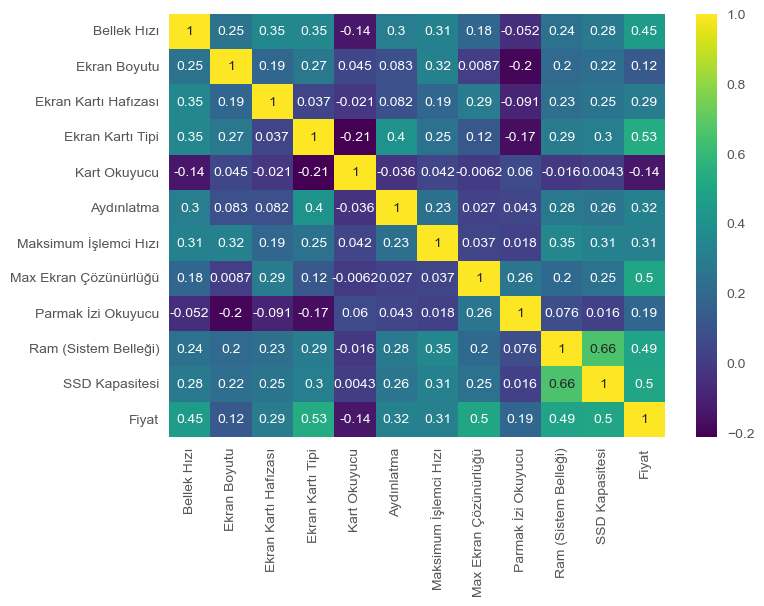

In [438]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="viridis");

## Data Preprocessing

In [439]:
X = df.drop("Fiyat", axis=1)
y = df[["Fiyat"]]

In [440]:
X = pd.get_dummies(X, drop_first=True)

In [441]:
X_copy = X.copy()

In [281]:
X.shape

(742, 149)

In [304]:
X = StandardScaler().fit_transform(X)

In [305]:
oversample = SMOTE()
X, y = oversample.fit_resample(X,y)

# Modelling

In [231]:
setup(df, target="Fiyat")

,Description,Value
0,Session id,8731
1,Target,Fiyat
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4"
4,Original data shape,"(742, 19)"
5,Transformed data shape,"(742, 45)"
6,Transformed train set shape,"(519, 45)"
7,Transformed test set shape,"(223, 45)"
8,Numeric features,11
9,Categorical features,7


In [232]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7398,0.0000,0.7398,0.7494,0.7365,0.6229,0.6268,0.0460
gbc,Gradient Boosting Classifier,0.7282,0.0000,0.7282,0.7322,0.7240,0.6074,0.6095,0.1060
xgboost,Extreme Gradient Boosting,0.7147,0.0000,0.7147,0.7239,0.7107,0.5875,0.5913,0.0390
lightgbm,Light Gradient Boosting Machine,0.7129,0.0000,0.7129,0.7176,0.7077,0.5834,0.5871,0.2400
et,Extra Trees Classifier,0.6993,0.0000,0.6993,0.7045,0.6932,0.5601,0.5646,0.0410
lda,Linear Discriminant Analysis,0.6764,0.0000,0.6764,0.6880,0.6732,0.5388,0.5418,0.0190
dt,Decision Tree Classifier,0.6646,0.0000,0.6646,0.6773,0.6629,0.5241,0.5283,0.0200
knn,K Neighbors Classifier,0.6532,0.0000,0.6532,0.6396,0.6362,0.4833,0.4903,0.0220
ridge,Ridge Classifier,0.6416,0.0000,0.6416,0.6307,0.6122,0.4556,0.4678,0.0200
ada,Ada Boost Classifier,0.5739,0.0000,0.5739,0.5784,0.5584,0.3926,0.4032,0.0310


In [306]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [307]:
rf = RandomForestClassifier()
model_rf = rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)
accuracy_score(predictions_rf,y_test)

0.906158357771261

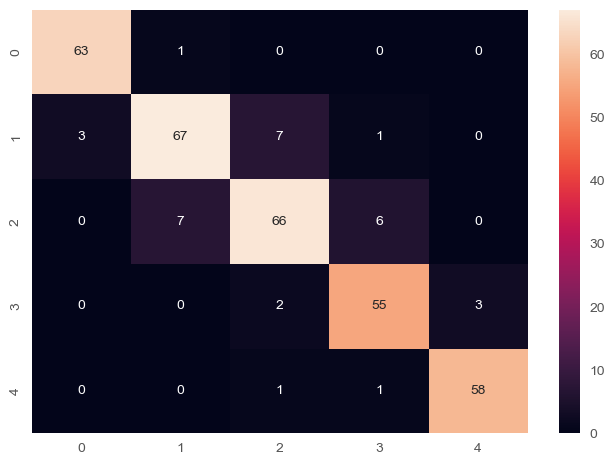

In [308]:
sns.heatmap(confusion_matrix(predictions_rf,y_test), annot=True);

In [309]:
print(classification_report(predictions_rf,y_test))

              precision    recall  f1-score   support

           1       0.95      0.98      0.97        64
           2       0.89      0.86      0.88        78
           3       0.87      0.84      0.85        79
           4       0.87      0.92      0.89        60
           5       0.95      0.97      0.96        60

    accuracy                           0.91       341
   macro avg       0.91      0.91      0.91       341
weighted avg       0.91      0.91      0.91       341



In [ ]:
## fit all datas not only train datas

In [310]:
model_rf = rf.fit(X,y)


In [311]:
joblib.dump(model_rf, "random_forest_model.pkl")

['random_forest_model.pkl']

## 2. phase--- predict the test data

In [359]:
dft = pd.read_excel("test.xlsx")
dft_copy = dft.copy()
dft.head()

,Bellek Hızı,Cihaz Ağırlığı,Ekran Boyutu,Ekran Kartı Bellek Tipi,Ekran Kartı Hafızası,Ekran Kartı Tipi,Ekran Panel Tipi,İşlemci Nesli,İşlemci,İşletim Sistemi,Kart Okuyucu,Aydınlatma,Maksimum İşlemci Hızı,Max Ekran Çözünürlüğü,Parmak İzi Okuyucu,Ram (Sistem Belleği),SSD Kapasitesi,Ürün Modeli,Fiyat
0,3200 MHz,1 - 2 kg,"15,6 inç",GDDR6,6 GB,Yüksek Seviye Harici Ekran Kartı,TN,12.Nesil,12450H,Yok (Free Dos),Yok,1,"4,4 GHz",1920 x 1080,Yok,8 GB,512 GB,Oyun Bilgisayarları,Orta
1,3200 MHz,1 - 2 kg,"14,1 inç",Onboard,Paylaşımlı,Dahili Ekran Kartı,IPS,12.Nesil,1255U,Yok (Free Dos),Var,0,"4,7 GHz",1920 x 1080,Var,16 GB,512 GB,Notebook,Düşük
2,3200 MHz,1 - 2 kg,"15,6 inç",Onboard,Paylaşımlı,Dahili Ekran Kartı,TN,Ryzen,5700U,Yok (Free Dos),Var,0,"4,3 GHz",1920 x 1080,Yok,8 GB,512 GB,Notebook,Çok Düşük
3,3200 MHz,1 - 2 kg,"15,6 inç",Onboard,Paylaşımlı,Dahili Ekran Kartı,IPS,12.Nesil,1255U,Windows 10 Pro,Var,0,"4,7 GHz",1920 x 1080,Yok,8 GB,2 TB,Notebook,Orta
4,2400 MHz,1 - 2 kg,"15,6 inç",Onboard,Paylaşımlı,Dahili Ekran Kartı,TN,İntel N Serisi,N4120,Yok (Free Dos),Var,0,"2,6 GHz",1366 x 768,Yok,4 GB,0 GB,Notebook,Çok Düşük


In [346]:
dft.shape

(249, 19)

In [360]:
def preprocess(df):
    df = df.drop("Fiyat", axis=1)
    df["Bellek Hızı"] = df["Bellek Hızı"].str.replace("MHz","").astype(int)
    df["Ekran Kartı Hafızası"] = df["Ekran Kartı Hafızası"].str.replace("GB","").str.replace("Paylaşımlı","5").astype(int)
    d = {"Dahili Ekran Kartı":1, "Harici Ekran Kartı":2, "Yüksek Seviye Harici Ekran Kartı":3}
    df["Ekran Kartı Tipi"] = df["Ekran Kartı Tipi"].map(d)
    df["Kart Okuyucu"] = df["Kart Okuyucu"].replace({"Yok":0, "Var":1}).astype(int)
    df["Parmak İzi Okuyucu"] = df["Parmak İzi Okuyucu"].replace({"Var":1, "Yok":0}).astype(int)
    df["Ram (Sistem Belleği)"] = df["Ram (Sistem Belleği)"].str.replace("GB","").astype(int)
    df["SSD Kapasitesi"] = df["SSD Kapasitesi"].str.replace("GB", "").str.replace("1 TB", "1024").str.replace("2 TB", "2048").str.replace("4 TB", "4096").astype(int)
    df["Cihaz Ağırlığı"] = df["Cihaz Ağırlığı"].replace({"1 - 2 kg":"2 kg ve Altı"})
    df["Ekran Boyutu"] = df["Ekran Boyutu"].str.replace("inç","").str.replace(",",".").astype(float)
    df["Maksimum İşlemci Hızı"] = df["Maksimum İşlemci Hızı"].str.replace("GHz", "").str.replace("Ghz","").str.replace(",", ".").astype("float")
    pixel = df["Max Ekran Çözünürlüğü"].str.split("x").to_list()
    df["Max Ekran Çözünürlüğü"] = list(map(lambda x: int(x[0]) * int(x[1]), pixel))
    df = pd.get_dummies(df, drop_first=True)
    df_scaled = StandardScaler().fit_transform(df)
    df = pd.DataFrame(df_scaled, columns=df.columns)
    
    return df
    
 

In [361]:
dft = preprocess(dft) 

In [362]:
dft.sample(5)

,Bellek Hızı,Ekran Boyutu,Ekran Kartı Hafızası,Ekran Kartı Tipi,Kart Okuyucu,Aydınlatma,Maksimum İşlemci Hızı,Max Ekran Çözünürlüğü,Parmak İzi Okuyucu,Ram (Sistem Belleği),SSD Kapasitesi,Cihaz Ağırlığı_2 kg ve Altı,Ekran Kartı Bellek Tipi_DDR5,Ekran Kartı Bellek Tipi_GDDR4,Ekran Kartı Bellek Tipi_GDDR5,Ekran Kartı Bellek Tipi_GDDR6,Ekran Kartı Bellek Tipi_GDDR6X,Ekran Kartı Bellek Tipi_Onboard,Ekran Panel Tipi_LED,Ekran Panel Tipi_OLED,Ekran Panel Tipi_TN,Ekran Panel Tipi_WVA,İşlemci Nesli_10.Nesil,İşlemci Nesli_11.Nesil,İşlemci Nesli_12.Nesil,İşlemci Nesli_13.Nesil,İşlemci Nesli_3.Nesil,İşlemci Nesli_4.Nesil,İşlemci Nesli_5.Nesil,İşlemci Nesli_6.Nesil,İşlemci Nesli_7.Nesil,İşlemci Nesli_Ryzen,İşlemci Nesli_İntel N Serisi,İşlemci_10110U,İşlemci_10300H,İşlemci_1035G1,İşlemci_1115G4,İşlemci_11260H,İşlemci_11300H,İşlemci_11320H,İşlemci_1135G7,İşlemci_11370H,İşlemci_11400H,İşlemci_1155G7,İşlemci_11600H,İşlemci_1165G7,İşlemci_11800H,İşlemci_1195G7,İşlemci_1235U,İşlemci_1240P,İşlemci_12450H,İşlemci_12500H,İşlemci_1255U,İşlemci_12650H,İşlemci_12700H,İşlemci_1280P,İşlemci_12900H,İşlemci_13420H,İşlemci_13700H,İşlemci_13700HX,İşlemci_13900HX,İşlemci_13980HX,İşlemci_3700U,İşlemci_4600H,İşlemci_5300U,İşlemci_5500U,İşlemci_5600H,İşlemci_5625U,İşlemci_5700U,İşlemci_5800H,İşlemci_6600H,İşlemci_6800H,İşlemci_6800HS,İşlemci_7320U,İşlemci_7735HS,İşlemci_AMD Ryzen 5,İşlemci_N3450,İşlemci_N4120,İşletim Sistemi_Windows 10 Home,İşletim Sistemi_Windows 10 Pro,İşletim Sistemi_Windows 11 Home,İşletim Sistemi_Windows 11 Pro,İşletim Sistemi_Yok (Free Dos),Ürün Modeli_Oyun Bilgisayarları,Ürün Modeli_İkisi Bir Arada
40,-1.16225,0.21268,0.00246,-0.88684,-1.02852,-0.60674,-4.87174,-0.20940,-0.53866,-0.93140,-0.46947,-1.18078,-0.06350,11.11306,-0.24408,-0.88959,-0.08998,-0.95676,5.16398,-0.11043,-0.53866,-0.20455,-0.18220,1.41421,-0.77875,-0.24408,-0.06350,-0.06350,-0.24408,-0.22502,-0.06350,-0.26205,-0.06350,-0.06350,-0.14315,-0.11043,-0.23470,-0.06350,-0.06350,-0.08998,2.75431,-0.06350,-0.17008,-0.11043,-0.06350,-0.23470,-0.21498,-0.06350,-0.33408,-0.11043,-0.15713,-0.22502,-0.33408,-0.14315,-0.25318,-0.06350,-0.06350,-0.06350,-0.18220,-0.11043,-0.06350,-0.06350,-0.06350,-0.08998,-0.06350,-0.11043,-0.19365,-0.12778,-0.11043,-0.15713,-0.11043,-0.12778,-0.14315,-0.06350,-0.06350,-0.06350,-0.06350,-0.06350,-0.20455,-0.20455,-0.45044,-0.30349,0.75891,-0.79212,-0.11043
48,-0.37708,0.21268,0.00246,-0.88684,0.97227,-0.60674,-0.06372,-0.20940,1.85646,1.77057,0.87527,0.84690,-0.06350,-0.08998,-0.24408,-0.88959,-0.08998,1.04520,-0.19365,-0.11043,-0.53866,-0.20455,-0.18220,-0.70711,1.28411,-0.24408,-0.06350,-0.06350,-0.24408,-0.22502,-0.06350,-0.26205,-0.06350,-0.06350,-0.14315,-0.11043,-0.23470,-0.06350,-0.06350,-0.08998,-0.36307,-0.06350,-0.17008,-0.11043,-0.06350,-0.23470,-0.21498,-0.06350,2.99333,-0.11043,-0.15713,-0.22502,-0.33408,-0.14315,-0.25318,-0.06350,-0.06350,-0.06350,-0.18220,-0.11043,-0.06350,-0.06350,-0.06350,-0.08998,-0.06350,-0.11043,-0.19365,-0.12778,-0.11043,-0.15713,-0.11043,-0.12778,-0.14315,-0.06350,-0.06350,-0.06350,-0.06350,-0.06350,-0.20455,-0.20455,-0.45044,-0.30349,0.75891,-0.79212,-0.11043
171,1.97551,0.89688,-0.61130,1.47491,0.97227,1.64816,0.65748,-0.20940,-0.53866,-0.03075,0.87527,-1.18078,-0.06350,-0.08998,-0.24408,1.12412,-0.08998,-0.95676,-0.19365,-0.11043,-0.53866,-0.20455,-0.18220,-0.70711,1.28411,-0.24408,-0.06350,-0.06350,-0.24408,-0.22502,-0.06350,-0.26205,-0.06350,-0.06350,-0.14315,-0.11043,-0.23470,-0.06350,-0.06350,-0.08998,-0.36307,-0.06350,-0.17008,-0.11043,-0.06350,-0.23470,-0.21498,-0.06350,-0.33408,-0.11043,-0.15713,4.44410,-0.33408,-0.14315,-0.25318,-0.06350,-0.06350,-0.06350,-0.18220,-0.11043,-0.06350,-0.06350,-0.06350,-0.08998,-0.06350,-0.11043,-0.19365,-0.12778,-0.11043,-0.15713,-0.11043,-0.12778,-0.14315,-0.06350,-0.06350,-0.06350,-0.06350,-0.06350,-0.20455,-0.20455,-0.45044,-0.30349,0.75891,1.26244,-0.11043
219,-0.37708,0.21268,0.00246,-0.88684,0.97227,-0.60674,-1.02532,-0.20940,-0.53866,1.77057,0.87527,0.84690,-0.

In [363]:
dft.shape

(249, 85)

In [352]:
model = joblib.load("random_forest_model.pkl")


In [444]:
missing_cols = set(X_copy.columns) - set(dft.columns)

for c in missing_cols:
    dft[c] = 0


dft = dft[X_copy.columns]

In [456]:
dft.head()

,Bellek Hızı,Ekran Boyutu,Ekran Kartı Hafızası,Ekran Kartı Tipi,Kart Okuyucu,Aydınlatma,Maksimum İşlemci Hızı,Max Ekran Çözünürlüğü,Parmak İzi Okuyucu,Ram (Sistem Belleği),SSD Kapasitesi,Cihaz Ağırlığı_2 kg ve Altı,Cihaz Ağırlığı_4 kg ve Üstü,Ekran Kartı Bellek Tipi_GDDR4,Ekran Kartı Bellek Tipi_GDDR5,Ekran Kartı Bellek Tipi_GDDR6,Ekran Kartı Bellek Tipi_GDDR6X,Ekran Kartı Bellek Tipi_Onboard,Ekran Panel Tipi_LED,Ekran Panel Tipi_LTPS,Ekran Panel Tipi_Liquid Retina Ekran,Ekran Panel Tipi_Liquid Retina XDR,Ekran Panel Tipi_Mini LED,Ekran Panel Tipi_OLED,Ekran Panel Tipi_SVA,Ekran Panel Tipi_TN,Ekran Panel Tipi_WVA,İşlemci Nesli_10. Nesil,İşlemci Nesli_10.Nesil,İşlemci Nesli_11. Nesil,İşlemci Nesli_11.Nesil,İşlemci Nesli_12,İşlemci Nesli_12. Nesil,İşlemci Nesli_12.Nesil,İşlemci Nesli_13.Nesil,İşlemci Nesli_3.Nesil,İşlemci Nesli_4.Nesil,İşlemci Nesli_5.Nesil,İşlemci Nesli_6.Nesil,İşlemci Nesli_7.Nesil,İşlemci Nesli_8.Nesil,İşlemci Nesli_9.Nesil,İşlemci Nesli_Apple M1,İşlemci Nesli_Apple M2,İşlemci Nesli_Apple M2 Max,İşlemci Nesli_Apple M2 Pro,İşlemci Nesli_M2,İşlemci Nesli_M2 Max,İşlemci Nesli_M2 Pro,İşlemci Nesli_Ryzen,İşlemci Nesli_Yok,İşlemci Nesli_İntel N Serisi,İşlemci_1000M,İşlemci_1005G1,İşlemci_10110U,İşlemci_10200H,İşlemci_10210U,İşlemci_10300H,İşlemci_1035G1,İşlemci_1035G16,İşlemci_10510U,İşlemci_1065G7,İşlemci_10750H,İşlemci_1115G4,İşlemci_1125G4,İşlemci_11260H,İşlemci_11320H,İşlemci_1135G7,İşlemci_11370H,İşlemci_11390H,İşlemci_11400H,İşlemci_1155G7,İşlemci_11600H,İşlemci_1165G7,İşlemci_11800H,İşlemci_1195G7,İşlemci_1215U,İşlemci_1235U,İşlemci_1240P,İşlemci_12450H,İşlemci_12500H,İşlemci_1255U,İşlemci_1260P,İşlemci_12650H,İşlemci_12700H,İşlemci_12800H,İşlemci_12900H,İşlemci_12900HK,İşlemci_13500H,İşlemci_13500HX,İşlemci_13620H,İşlemci_13650HX,İşlemci_13700H,İşlemci_13700HX,İşlemci_13900H,İşlemci_13900HX,İşlemci_13980HX,İşlemci_3250U,İşlemci_3700U,İşlemci_4600H,İşlemci_5257U,İşlemci_5300U,İşlemci_5500U,İşlemci_5600H,İşlemci_5625U,İşlemci_5675U,İşlemci_5700U,İşlemci_5800H,İşlemci_5825U,İşlemci_5900HX,İşlemci_6600H,İşlemci_6800H,İşlemci_6800HS,İşlemci_7320U,İşlemci_7520U,İşlemci_7530U,İşlemci_7730U,İşlemci_7735HS,İşlemci_7940HS,İşlemci_7Y57,İşlemci_7Y75,İşlemci_8565U,İşlemci_9300H,İşlemci_9880H,İşlemci_AMD R7-5700U,İşlemci_AMD Ryzen 5,İşlemci_Apple M1,İşlemci_Apple M2,İşlemci_Apple M2 Max,İşlemci_Apple M2 Pro,İşlemci_Celeron N4020,İşlemci_N4000,İşlemci_N4020,İşlemci_N4120,İşlemci_N4150,İşlemci_N4500,İşlemci_N5030,İşlemci_T5600,İşletim Sistemi_Chrome OS,İşletim Sistemi_Ubuntu,İşletim Sistemi_Windows 10 Home,İşletim Sistemi_Windows 10 Pro,İşletim Sistemi_Windows 11 Home,İşletim Sistemi_Windows 11 Pro,İşletim Sistemi_Yok (Free Dos),İşletim Sistemi_macOS,Ürün Modeli_Oyun Bilgisayarları,Ürün Modeli_Ultrabook,Ürün Modeli_İkisi Bir Arada
0,-0.37708,0.21268,0.61623,1.47491,-1.02852,1.64816,-0.06372,-0.20940,-0.53866,-0.93140,-0.46947,0.84690,0,-0.08998,-0.24408,1.12412,-0.08998,-0.95676,-0.19365,0,0,0,0,-0.11043,0,1.85646,-0.20455,0,-0.18220,0,-0.70711,0,0,1.28411,-0.24408,-0.06350,-0.06350,-0.24408,-0.22502,-0.06350,0,0,0,0,0,0,0,0,0,-0.26205,0,-0.06350,0,0,-0.06350,0,0,-0.14315,-0.11043,0,0,0,0,-0.23470,0,-0.06350,-0.08998,-0.36307,-0.06350,0,-0.17008,-0.11043,-0.06350,-0.23470,-0.21498,-0.06350,0,-0.33408,-0.11043,6.36396,-0.22502,-0.33408,0,-0.14315,-0.25318,0,-0.06350,0,0,0,0,0,-0.18220,-0.11043,0,-0.06350,-0.06350,0,-0.06350,-0.08998,0,-0.06350,-0.11043,-0.19365,-0.12778,0,-0.11043,-0.15713,0,0,-0.11043,-0.12778,-0.14315,-0.06350,0,0,0,-0.06350,0,0,0,0,0,0,0,-0.06350,0,0,0,0,0,0,0,-0.06350,0,0,0,0,0,0,-0.20455,-0.20455,-0.45044,-0.30349,0.75891,0,1.26244,0,-0.11043
1,-0.37708,-1.83993,0.00246,-0.88684,0.97227,-0.60674,0.65748,-0.20940,1.85646,-0.03075,-0.46947,0.84690,0,-0.08998,-0.24408,-0.88959,-0.08998,1.04520,-0.19365,0,0,0,0,-0.11043,0,-0.53866,-0.20455,0,-0.18220,0,-0.70711,0,0,1.28411,-0.24408,-0.06350,-0.06350,-0.24408,-0.22502,-0.06350,0,0,0,0,0,0,0,0,0,-0.26205,0,-0.06350,0,0,-0.06350,0,0,-0.14315,-0.11043,0,0,0,0,

In [445]:
predictions = model.predict(dft)
predictions

array([4, 3, 1, 3, 1, 1, 3, 2, 1, 3, 2, 2, 2, 1, 3, 1, 3, 4, 2, 4, 2, 2,
       3, 1, 4, 1, 1, 4, 2, 3, 3, 2, 1, 3, 4, 2, 3, 3, 3, 3, 1, 3, 3, 1,
       1, 3, 3, 1, 2, 2, 4, 1, 3, 2, 3, 3, 3, 3, 1, 1, 3, 1, 2, 4, 1, 2,
       3, 3, 2, 1, 1, 2, 3, 5, 2, 3, 5, 3, 4, 3, 1, 1, 3, 4, 3, 4, 3, 3,
       5, 2, 2, 3, 4, 4, 3, 1, 2, 3, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 5, 1,
       1, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 3, 4, 4, 3, 5, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4,
       3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 2, 3, 4, 2, 3, 3, 3,
       2, 3, 3, 1, 2, 2, 2, 2, 1, 1, 2, 3, 2, 3, 3, 1, 3, 2, 2, 2, 2, 2,
       2, 1, 2, 3, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       3, 1, 3, 2, 3, 2, 2, 2, 2, 3, 1, 1, 2, 2, 1, 2, 2, 2, 2, 3, 1, 1,
       1, 2, 2, 2, 2, 2, 2])

In [451]:
y_test = dft_copy[["Fiyat"]]
y_test = y_test.replace({"Çok Düşük":1,
                                   "Düşük": 2,
                                   "Orta": 3,
                                   "Yüksek": 4,
                                   "Çok Yüksek": 5,
                                  }).astype(int)

In [452]:
accuracy_score(y_test, predictions)

0.678714859437751

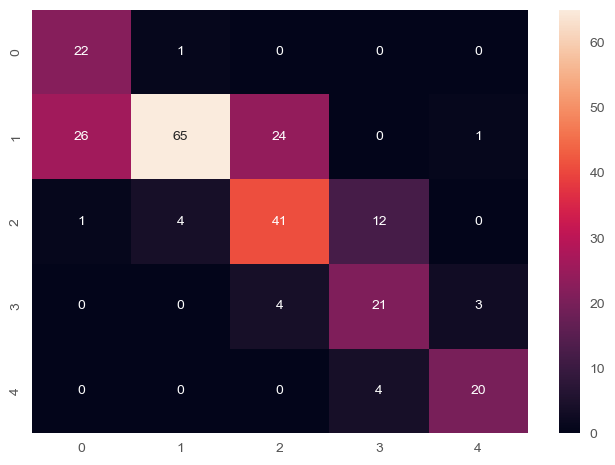

In [454]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True);

In [455]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           1       0.96      0.45      0.61        49
           2       0.56      0.93      0.70        70
           3       0.71      0.59      0.65        69
           4       0.75      0.57      0.65        37
           5       0.83      0.83      0.83        24

    accuracy                           0.68       249
   macro avg       0.76      0.67      0.69       249
weighted avg       0.73      0.68      0.67       249

